In [1]:
import numpy as np
import matplotlib.pyplot as plt

RANGE = 6
SAMPLES = 6
ALPHA_TIME = 2.5 # total_time = SUM(ALPHA_TIME * dist_{i,i+1})
SEED = 42

Genero una serie de puntos aleatorios

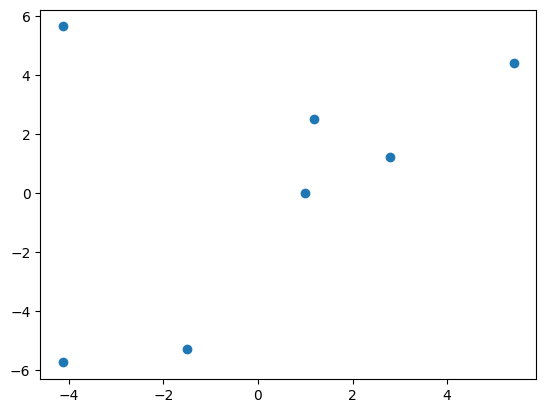

In [2]:
np.random.seed(SEED)
xs = np.concatenate([[1], np.random.uniform(-RANGE, RANGE, SAMPLES)])
ys = np.concatenate([[0], np.random.uniform(-RANGE, RANGE, SAMPLES)])
plt.scatter(xs, ys)

Calculo la secuencia mas corta para recorrerlos

Vease https://developers.google.com/optimization/routing/tsp

In [3]:
def create_data_model(x, y):
    """Stores the data for the problem."""
    data = {}
    data["locations"] = list(zip(x, y))
    data["distance_matrix"] = np.zeros((len(data["locations"]), len(data["locations"])))
    for i in range(len(data["locations"])):
        for j in range(len(data["locations"])):
            data["distance_matrix"][i][j] = np.linalg.norm(np.array(data["locations"][i]) - np.array(data["locations"][j]))
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data

In [4]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

data = create_data_model(xs, ys)
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)
routing = pywrapcp.RoutingModel(manager)

In [5]:
def distance_callback(from_index, to_index, manager=manager, data=data):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(data["distance_matrix"][from_node][to_node])

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Funcion objetivo
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [6]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromMilliseconds(1000)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [7]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    plan_output += f"Route distance: {route_distance/1000}\n"
    print(plan_output)

In [8]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

Objective: 34
Route for vehicle 0:
 0 -> 3 -> 2 -> 4 -> 6 -> 5 -> 1 -> 0
Route distance: 0.034



In [9]:
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    time = [0]
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        location_index = manager.IndexToNode(index)
        route = [data["locations"][location_index]]
        while not routing.IsEnd(index):
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            location_index = manager.IndexToNode(index)
            route.append(data["locations"][location_index])
            time.append(time[-1] + ALPHA_TIME * data['distance_matrix'][previous_index][location_index])
        routes.append(route)
    return np.array(routes[0]), np.array(time)

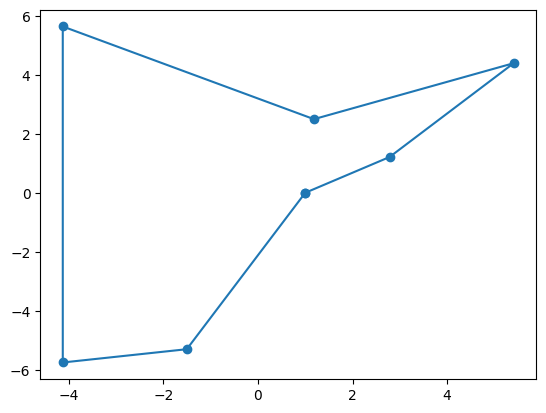

In [10]:
data['locations_sorted'], data['time_sorted'] = get_routes(solution, routing, manager)

plt.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], marker='o')

### Splines
Genero una curva spline que pase por esos puntos en ese orden

#### Recorrido exacto (CubicSpline)

In [11]:
from scipy.interpolate import CubicSpline

# Create separate splines for x and y coordinates
cs_x = CubicSpline(data['time_sorted'], data['locations_sorted'][:, 0], bc_type='natural') # f(x(t))
cs_y = CubicSpline(data['time_sorted'], data['locations_sorted'][:, 1], bc_type='natural') # f(y(t))

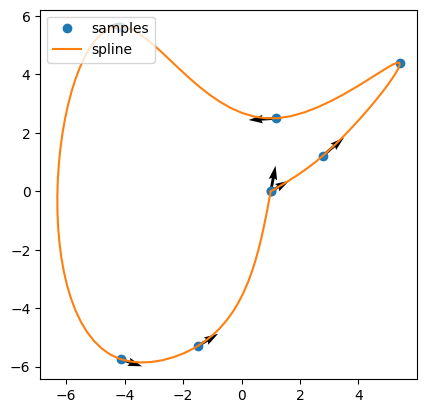

In [12]:
ts_new = np.linspace(0, max(data['time_sorted']), 100)

fig, ax = plt.subplots()
ax.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], 'o', label='samples')
ax.plot(cs_x(ts_new), cs_y(ts_new), label='spline')
ax.axes.set_aspect('equal')
ax.legend(loc='upper left')

# Derivadas
dxdt = cs_x.derivative()(data['time_sorted'])
dydt = cs_y.derivative()(data['time_sorted'])
ax.quiver(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], dxdt, dydt)
plt.show()

In [13]:
# calculo los angulos
angles = np.arctan2(dydt, dxdt)
angles

array([ 0.52140751,  0.7136143 ,  2.21959917, -3.0811794 ,  3.07100229,
       -0.31822367,  0.54433428,  1.3866512 ])

In [14]:
data['spline_waypoints'] = np.concatenate((data['time_sorted'][:, None] + 2.5, data['locations_sorted'], angles[:, None]), axis=1)
data['spline_waypoints'] = np.concatenate((np.array([[0., 0., 0., 0.]]), data['spline_waypoints']))
print(data['spline_waypoints'])
data['spline_waypoints'] = data['spline_waypoints'].reshape(-1).round(8).tolist() # Listo para copiar y pegar en el launch

[[ 0.          0.          0.          0.        ]
 [ 2.5         1.          0.          0.52140751]
 [ 7.89368148  2.7839273   1.21338014  0.7136143 ]
 [18.20321117  5.40857168  4.39411375  2.21959917]
 [29.78103636  1.18390181  2.49687093 -3.0811794 ]
 [45.21020124 -4.12806576  5.63891823  3.07100229]
 [73.68996198 -4.12777631 -5.75298607 -0.31822367]
 [80.34143087 -1.50551857 -5.30299665  0.54433428]
 [95.00418062  1.          0.          1.3866512 ]]


##### Recorrido aproximado (splprep, splev)
Parametro s: smooth factor

In [15]:
from scipy.interpolate import splprep, splev
tck, u = splprep(data['locations_sorted'].T, s=1)
x_i,y_i= splev(np.linspace(0, 1, 100),tck)

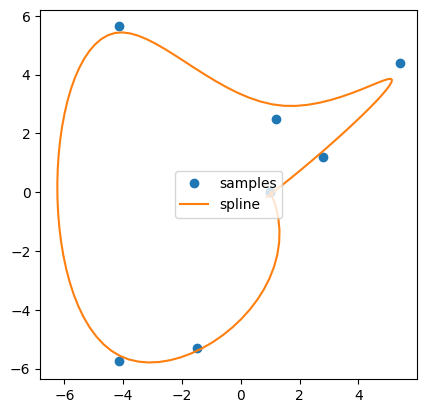

In [16]:
fig, ax = plt.subplots()
ax.plot(data['locations_sorted'][:, 0], data['locations_sorted'][:, 1], 'o', label='samples')
ax.plot(x_i, y_i, label='spline')
ax.axes.set_aspect('equal')
ax.legend(loc='center')
plt.show()

In [17]:
# Idem derivadas y angulos para este caso
u_new = np.linspace(0, 1, len(u))
x_aprox, y_aprox = splev(u_new, tck)
dxdu, dydu = splev(u_new, tck, der=1)
angles_aprox = np.arctan2(dydu, dxdu)
param_aprox = np.linspace(0, max(data['time_sorted']), len(u_new))

waypoints_aprox = np.column_stack((param_aprox, x_aprox, y_aprox, angles_aprox))
print(waypoints_aprox)
data["spline_waypoints_aprox"] = waypoints_aprox.reshape(-1).round(8).tolist()

[[ 0.00000000e+00  8.89941219e-01 -1.59308179e-01  6.53195668e-01]
 [ 1.32148829e+01  5.07324375e+00  3.65229495e+00  1.00065118e+00]
 [ 2.64297659e+01  1.76163663e+00  2.93413919e+00 -3.12475395e+00]
 [ 3.96446488e+01 -3.31729736e+00  5.25860449e+00  2.74117291e+00]
 [ 5.28595318e+01 -6.04335422e+00  2.43472304e+00 -1.75271876e+00]
 [ 6.60744147e+01 -5.39030733e+00 -4.16339810e+00 -1.10172115e+00]
 [ 7.92892977e+01 -1.00911007e+00 -5.13199923e+00  5.52578342e-01]
 [ 9.25041806e+01  1.00814521e+00  1.26567282e-02  1.99375600e+00]]
